# Time Series Analysis Using SQL

In this project, is used to analyze trend of sales and forecasting using moving average method
Project is using SQL programming but connecting with python to make it easier

In [2]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


## Connecting python with sql server

### Import Libraries and Create Connection

In [39]:
import requests
import mysql.connector

cnx = mysql.connector.connect(user ='root', password= 'Arr2@dan3', host = 'localhost',port='3306', database='northwind')

cursor = cnx.cursor()

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200

C:\Users\user\AppData\Local\Temp\ipykernel_8840\1850576888.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [41]:
# create a function to save sql query and display the result in dataframe format
def sql(yourQuery):
    cursor.execute(yourQuery)
    myresult = cursor.fetchall()
    df = pd.DataFrame(myresult, columns = cursor.column_names)
    return df

# Data Prepocessing

In this project using dataset sales that get from Maven Analytics platform, and there is consist for several table
- order : the table contains details related to order
- order_detail : contains detail
- customer : contains detail customer information
- product : contain detail product that company sell
- categories :contain detail about category of product 

In [4]:
sql(
    '''
    SELECT *
    FROM orders
    LIMIT 5;
    '''
)

,orderID,customerID,employeeID,orderDate,requiredDate,shippedDate,shipperID,freight
0,10248,VINET,5,2013-07-04,2013-08-01,2013-07-16,3,32.38
1,10249,TOMSP,6,2013-07-05,2013-08-16,2013-07-10,1,11.61
2,10250,HANAR,4,2013-07-08,2013-08-05,2013-07-12,2,65.83
3,10251,VICTE,3,2013-07-08,2013-08-05,2013-07-15,1,41.34
4,10252,SUPRD,4,2013-07-09,2013-08-06,2013-07-11,2,51.30


## Daily Average Sales

In [11]:
average = sql(
    '''
    WITH analyze_sales AS (
    SELECT 
        a.orderID, 
        SUM(b.quantity*b.unitPrice) as gross_revenue 
    FROM orders as a
    INNER JOIN order_detail as b
    ON a.orderID = b.orderID
    GROUP BY a.orderID ),
    average_monthlysales AS(SELECT DAY(orderDate) as order_day ,ROUND(AVG(b.quantity*b.unitPrice),2) as average_sales 
    FROM orders as a
    INNER JOIN order_detail as b
    ON a.orderID = b.orderID GROUP BY order_day)
    
    SELECT * FROM average_monthlysales ORDER BY order_day;
    '''
)

average

,order_day,average_sales
0,1,794.94
1,2,804.32
2,3,597.54
3,4,608.57
4,5,529.10
5,6,517.90
6,7,324.90
7,8,590.46
8,9,487.01
9,10,666.23


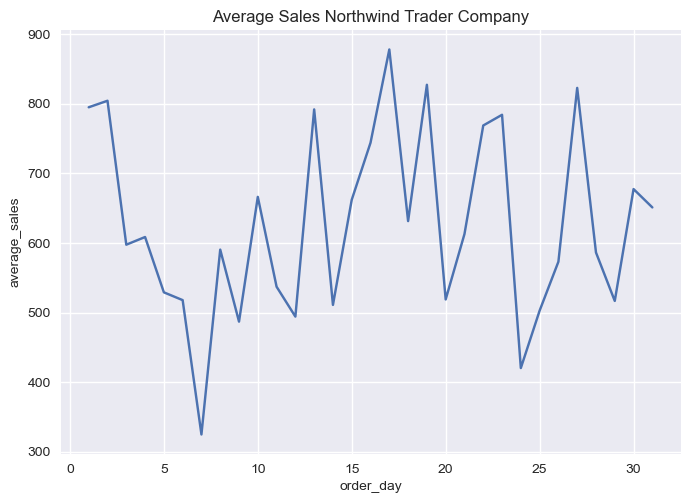

In [28]:
sns.lineplot(data=average, x="order_day", y="average_sales").set(title='Average Sales Northwind Trader Company')
plt.show()

## Average Sales Monthly

In [26]:
monthly_sales = sql(
    '''
    WITH analyze_sales AS (
    SELECT a.orderID, SUM(b.quantity*b.unitPrice) as gross_revenue FROM orders as a
    INNER JOIN order_detail as b
    ON a.orderID = b.orderID
    GROUP BY a.orderID ),
    average_monthlysales AS (SELECT DATE_FORMAT(orderDate, '%Y-%m-%d') order_day ,ROUND(AVG(b.quantity*b.unitPrice),2) as average_sales 
    FROM orders as a
    INNER JOIN order_detail as b
    ON a.orderID = b.orderID GROUP BY order_day)
    
    SELECT * FROM average_monthlysales ORDER BY order_day
    '''
)
monthly_sales

,order_day,average_sales
0,2013-07-04,146.67
1,2013-07-05,931.70
2,2013-07-08,413.97
3,2013-07-09,1243.33
4,2013-07-10,481.60
...,...,...
475,2015-04-30,341.19
476,2015-05-01,590.36
477,2015-05-04,566.33
478,2015-05-05,658.46


In [31]:
data_2013 = monthly_sales.loc[monthly_sales.order_day == "2013"]
data_2013.head()

,order_day,average_sales


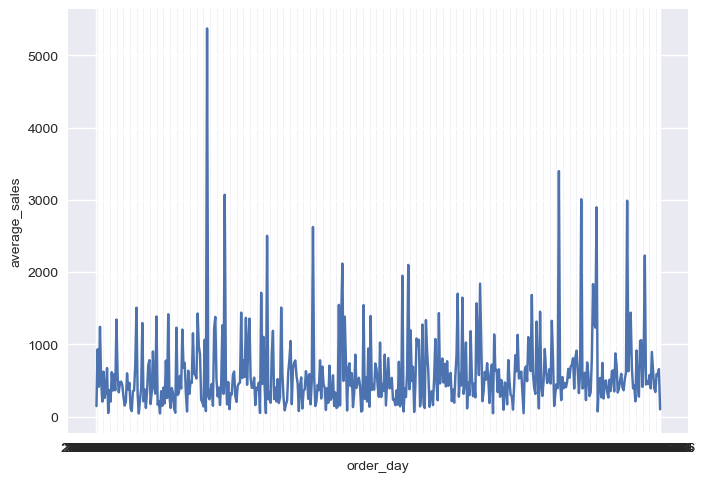

In [16]:
sns.lineplot(data=monthly_sales, x="order_day", y="average_sales")
plt.show()

In [7]:
sql(
    '''
    SELECT *
    FROM order_details
    LIMIT 5;
    '''
)

,orderID,productID,unitPrice,quantity,discount
0,10248,11,14.0,12,0
1,10248,42,9.8,10,0
2,10248,72,34.8,5,0
3,10249,14,18.6,9,0
4,10249,51,42.4,40,0


## Previous day comparison

LAG Function 
lag function is used to SQL LAG() is a window function that provides access to a row at a specified physical offset which comes before the current row. In other words, by using the LAG() function, from the current row, you can access data of the previous row, or from the second row before the current row, or from the third row before current row, and so on.

In this case, we use lag function to comparison sales on previous day so we can know how much percent decrease or increase each day

In [40]:
sql(
    '''
    WITH analyze_sales AS (
        SELECT orderDate, SUM(b.quantity*b.unitPrice) as gross_revenue,
        LAG(SUM(b.quantity*b.unitPrice)) OVER(ORDER BY a.orderDate) as previous_revenue FROM orders as a
        INNER JOIN order_detail as b
        ON a.orderID = b.orderID
        GROUP BY a.orderDate )
    
    SELECT orderDate,gross_revenue, previous_revenue, 
    ROUND((gross_revenue-previous_revenue)/previous_revenue*100,2) as percentchangevs_lastday FROM analyze_sales
    '''
)

,orderDate,gross_revenue,previous_revenue,percentchangevs_lastday
0,2013-07-04,440.00,NaN,NaN
1,2013-07-05,1863.40,440.00,323.50
2,2013-07-08,2483.80,1863.40,33.29
3,2013-07-09,3730.00,2483.80,50.17
4,2013-07-10,1444.80,3730.00,-61.27
...,...,...,...,...
475,2015-04-30,2729.50,2741.00,-0.42
476,2015-05-01,5903.61,2729.50,116.29
477,2015-05-04,2831.65,5903.61,-52.04
478,2015-05-05,7901.50,2831.65,179.04


## Rank of Product Sales Based on Category

Rank is one of window function 

In [57]:
sql(
    '''
    WITH analyze_sales AS (
        SELECT orderID, productID, (a.quantity*a.unitPrice) as gross_revenue FROM order_detail as a
        )
    SELECT country, productName,SUM(gross_revenue),RANK() OVER(PARTITION BY country ORDER BY SUM(gross_revenue)) as ranking FROM analyze_sales as a
    INNER JOIN orders as b
    ON a.orderID = b.orderID
    INNER JOIN customers as c
    ON b.customerID = c.customerID
    INNER JOIN products as d
    ON a.productID = d.productID
    GROUP BY productName,country
    
    '''
)

,country,productName,SUM(gross_revenue),ranking
0,Argentina,Gorgonzola Telino,12.50,1
1,Argentina,Geitost,25.00,2
2,Argentina,Konbu,30.00,3
3,Argentina,Spegesild,36.00,4
4,Argentina,Maxilaku,40.00,5
...,...,...,...,...
931,Venezuela,Gudbrandsdalsost,2174.40,49
932,Venezuela,Gumbär Gummibärchen,2299.23,50
933,Venezuela,Rössle Sauerkraut,2736.00,51
934,Venezuela,Mozzarella di Giovanni,2977.60,52


## Moving Average

In [42]:
sql(
    '''
    WITH analyze_sales AS (
        SELECT orderDate, SUM(b.quantity*b.unitPrice) as gross_revenue FROM orders as a
        INNER JOIN order_detail as b
        ON a.orderID = b.orderID
        GROUP BY a.orderDate )
    
    SELECT *,  
    SUM(gross_revenue) OVER(Order By orderDate ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) as SMA7 FROM analyze_sales
    '''
)

,orderDate,gross_revenue,SMA7
0,2013-07-04,440.00,440.00
1,2013-07-05,1863.40,2303.40
2,2013-07-08,2483.80,4787.20
3,2013-07-09,3730.00,8517.20
4,2013-07-10,1444.80,9962.00
...,...,...,...
475,2015-04-30,2729.50,25637.10
476,2015-05-01,5903.61,28837.96
477,2015-05-04,2831.65,28204.51
478,2015-05-05,7901.50,34148.51


# Analysis discount of 2 concecutive days 

..

In [17]:
concecutive= sql(
    '''
    WITH analyze_discount AS
    (SELECT orderDate,discount,
    AVG(discount) OVER(partition by productID order by orderDate ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) as concecutive_2day
    FROM orders as a
    INNER JOIN order_detail as b
    ON a.orderID = b.orderID)
    
    SELECT * FROM analyze_discount
    
    '''
)
concecutive

,orderDate,discount,concecutive_2day
0,2013-08-20,0.20,0.200000
1,2013-08-30,0.00,0.100000
2,2013-09-30,0.00,0.066667
3,2013-11-07,0.15,0.050000
4,2013-11-14,0.00,0.050000
...,...,...,...
2150,2015-04-06,0.00,0.016667
2151,2015-04-10,0.00,0.016667
2152,2015-04-30,0.00,0.000000
2153,2015-05-04,0.15,0.050000


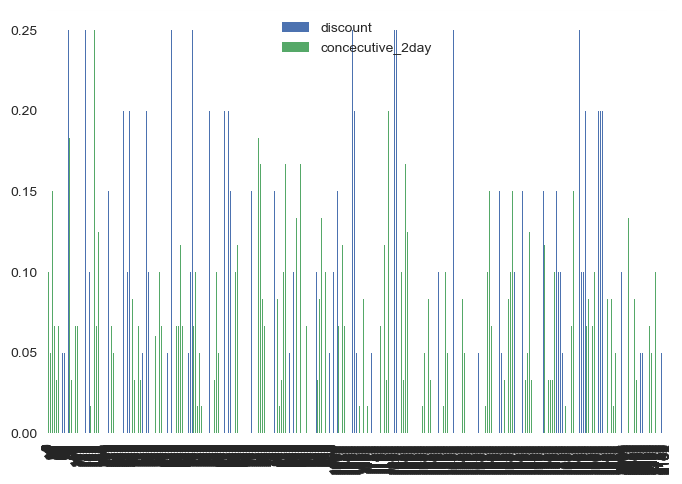

In [20]:
concecutive.plot(kind='bar')
plt.show()